# Progress Report

## Project Introduction

This project analyzes cancer trends in California with a focus on the potential impact of water quality, specifically PFAS contamination, on public health. It investigates whether higher PFAS levels correlate with increased cancer rates, especially in low-income communities.

The analysis uses three main data sources:
1. California Cancer Dataset (2017–2021): Over 4,500 records of county-level cancer rates by type, ethnicity, gender, and age-adjusted values.
2. California PFAS Dataset (2014–2016): More than 680,000 groundwater sampling records tracking PFAS contamination and water quality.
3. 2022 County Shapefiles: Geographic boundaries to link cancer and PFAS data to specific counties.

The goal is to identify whether environmental water contamination is associated with higher cancer incidence across California.

Notebook: https://github.com/uic-cs418/group-project-data-engineers/blob/main/Progress-report.ipynb

## Changes to Scope:

The scope of the project has narrowed slightly, with a shift away from exploring all water contaminants in favor of a more focused investigation into PFAS and its direct correlation with cancer rates.

This refined approach aims to provide actionable insights into the link between water quality and public health, particularly cancer incidence, and offer policy recommendations based on the findings.


In [ ]:
! pip install pandas matplotlib seaborn geopandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Cleaning

### Cancer Dataset


The cancer dataset includes county-level statistics by sex and cancer type, with key fields such as AAIR, total population, and demographic percentages. It spans all California counties over two periods: 2011–2021 (10-year) and 2017–2021 (5-year). Data is sourced from California Health Maps, ensuring faithfulness and standardized metrics. For cleaning, only 2017–2021 records were kept to align with PFAS data, and rows missing AAIR were dropped. "Both sexes" entries were removed to avoid redundancy. Where rows aggregated multiple counties, values were redistributed proportionally based on population and sex. Cancer incidents were calculated using AAIR and population, and AAIR was recomputed where needed. These steps ensured consistent granularity, scope, and structure for analysis.


In [2]:
cancer_df = pd.read_csv("data/raw/californiahealthmaps_county_all.csv")
cancer_df.head(1)

,AreaID,Counties,Cities,URL,Sex,Cancer,Years,PopTot,AAIR,LCI,...,PerWhite,PerBlack,PerAsian,PerHispanic,PerDocVisit,PerFOBT,PerMammo,PerMenPrev,PerCervical,PerWomenPrev
0,1,Alameda,"Livermore, Dublin, Berkeley, Hayward, Alameda,...",https://www.californiahealthmaps.org?areatype=...,Both,Prostate,05yr,8360006,42.4,41.2,...,32.3,11.0,34.1,22.2,61.1,61.0,71.6,38.2,79.0,30.9


In [3]:
cancer_df.isna().sum()[:11]

AreaID        0
Counties      0
Cities      702
URL           0
Sex           0
Cancer        0
Years         0
PopTot        0
AAIR        299
LCI         299
UCI         299
dtype: int64

In [4]:
from cancer_data_cleaning import clean_cancer_data, split_combined_counties

cancer_df = clean_cancer_data(cancer_df)
cancer_df.head(3)


,Counties,Sex,Cancer,PopTot,AAIR,Cancer_Incidents
1,Alameda,Male,Prostate,4150512,91.9,3814.320528
2,Alameda,Female,Prostate,4209494,0.0,0.000000
4,Alameda,Male,Breast,4150512,1.2,49.806144


In [5]:
combined_counties = cancer_df['Counties'][cancer_df['Counties'].str.contains(',')].unique()
combined_counties

array(['Tulare, Fresno', 'Shasta, Tehama', 'Ventura, Kern'], dtype=object)

In [6]:
cancer_df = split_combined_counties(cancer_df)
cancer_df[cancer_df['county'] == 'Tulare'].head(5)

,county,Sex,Cancer,PopTot,AAIR,Cancer_Incidents
1321,Tulare,Male,Prostate,1183384.0,91.9,1087.529896
1322,Tulare,Female,Prostate,1171391.0,0.0,0.000000
1323,Tulare,Male,Breast,1183384.0,0.5,5.916920
1324,Tulare,Female,Breast,1171391.0,105.0,1229.960550
1325,Tulare,Male,Lung,1183384.0,35.4,418.917936


### PFAS Dataset

The PFAS dataset records individual chemical measurements at California water wells from 2016–2024, including well metadata, chemical names, and result values. Each row represents one compound at a specific location and time. The data focuses on PFAS compounds like PFNA and NMEFOSAA, mostly from municipal sources, and comes from the Division of Drinking Water. 

In [7]:
pfas_df = pd.read_csv('data/raw/pfas.zip', compression='zip', encoding='ISO-8859-1')
pfas_df.head(2).iloc[:, 4:13]

/tmp/ipykernel_132603/121182058.py:1: DtypeWarning: Columns (20,26,27,29,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  pfas_df = pd.read_csv('data/raw/pfas.zip', compression='zip', encoding='ISO-8859-1')


,gm_chemical_vvl,gm_chemical_name,gm_result_modifier,gm_result,gm_chemical_units,gm_reporting_limit,gm_samp_collection_date,gm_latitude,gm_longitude
0,NMEFOSAA,N-Methyl perfluorooctane sulfonamidoacetic aci...,<,1.7,NG/L,1.7,2021-12-19,41.781029,-124.2006
1,PFNA,Perfluorononanoic acid (PFNA),<,1.7,NG/L,1.7,2021-03-30,41.781029,-124.2006


PFAS data was filtered to include only measurements from 2017 to 2021, dropping rows missing chemical values (gm_result). Key fields such as chemical abbreviation, measurement (ng/L), sample date, and coordinates were extracted. Latitude and longitude were mapped to counties using the 2022 Census Shapefile. The data was then reshaped into a wide format with each chemical as a column, missing values filled with the county’s annual average, and finally merged with the cancer dataset for analysis.

In [8]:
from pfas_data_cleaner import (fill_missing_values, filter_date_range, remove_missing_results,
    extract_relevant_columns, load_county_shapefile, calculate_county_bounds, get_california_counties,
    add_county_column, create_wide_format, calculate_total_pfas)

pfas_df = filter_date_range(pfas_df, '2017-01-01', '2021-12-31')
pfas_df = remove_missing_results(pfas_df)
pfas_df = extract_relevant_columns(pfas_df)

pfas_df.head(2)

,gm_chemical_vvl,gm_result,gm_samp_collection_date,gm_latitude,gm_longitude
551931,NMEFOSAA,12.0,2021-12-31,35.956463,-120.011327
572532,PFUNDCA,11.0,2021-12-31,35.956463,-120.011327


In [10]:
gdf = load_county_shapefile('data/raw/tl_2022_us_county.zip')

county_bounds = calculate_county_bounds(gdf)
california_counties = get_california_counties()
california_county_bounds = {name: county_bounds[name] for name in california_counties}

# Add county information
pfas_df = add_county_column(pfas_df, california_county_bounds)
pfas_df = pfas_df[['gm_chemical_vvl', 'gm_result', 'gm_samp_collection_date', 'county']]

pfas_df.head(2)

,gm_chemical_vvl,gm_result,gm_samp_collection_date,county
551931,NMEFOSAA,12.0,2021-12-31,Fresno
572532,PFUNDCA,11.0,2021-12-31,Fresno


In [11]:
pfas_df = create_wide_format(pfas_df)
pfas_df = fill_missing_values(pfas_df)
pfas_df = calculate_total_pfas(pfas_df)

final_df = pd.merge(pfas_df, cancer_df, on='county', how='inner')
final_df.head(2)

,county,gm_samp_collection_date,10:2FTS,11ClPF3OUDS,3:3FTCA,4:2FTS,5:3FTCA,6:2FTS,7:3FTCA,8:2FTS,...,PFPES,PFTEDA,PFTRIDA,PFUNDCA,total_pfas_concentration,Sex,Cancer,PopTot,AAIR,Cancer_Incidents
0,Yuba,2021-11-18,2.322092,2.0,4.251273,7.616667,3.418426,7.616667,5.346817,7.616667,...,1.922222,2.0,2.0,2.0,178.339414,Male,Prostate,205837.0,116.2,239.182594
1,Yuba,2021-11-18,2.322092,2.0,4.251273,7.616667,3.418426,7.616667,5.346817,7.616667,...,1.922222,2.0,2.0,2.0,178.339414,Female,Prostate,196337.0,0.0,0.000000


## Exploratory Data Analysis

In [12]:
df = pd.read_csv('cleaned_pfas_cancer_merged.csv')

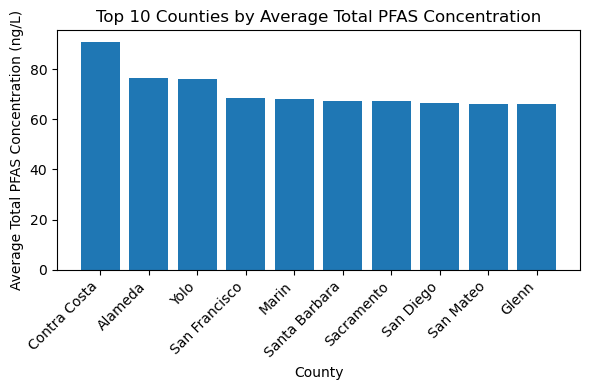

In [13]:
from visualizations import get_top_ten_cancer_counties, get_top_ten_pfas_counties, hypothesis_plot
plot = get_top_ten_pfas_counties(df)

plot.show()

/home/shayan283/anaconda3/envs/cs418env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


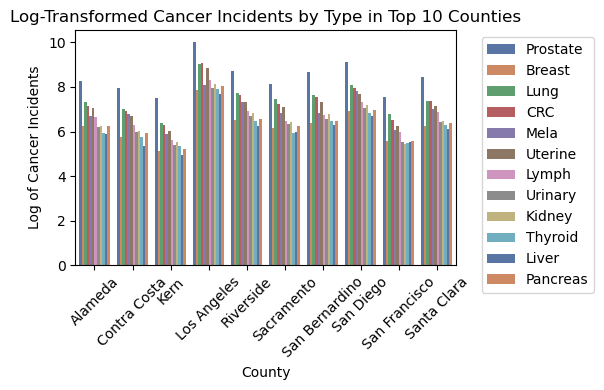

In [14]:
plot = get_top_ten_cancer_counties(df)
plt.show()

Counties in California with higher PFAS concentrations tend to show higher rates of total cancer incidents, indicating a moderate positive correlation. Notably, counties like Contra Costa, Alameda, and San Diego appear in both the highest PFAS and high cancer incidence groups. San Francisco had a high concatenation but a relatively lower level of cancer incidents.

## 🔬 PFAS vs Cancer Rate – Hypothesis Testing
This section explores whether higher PFAS levels are associated with increased cancer rates (AAIR) across California counties.

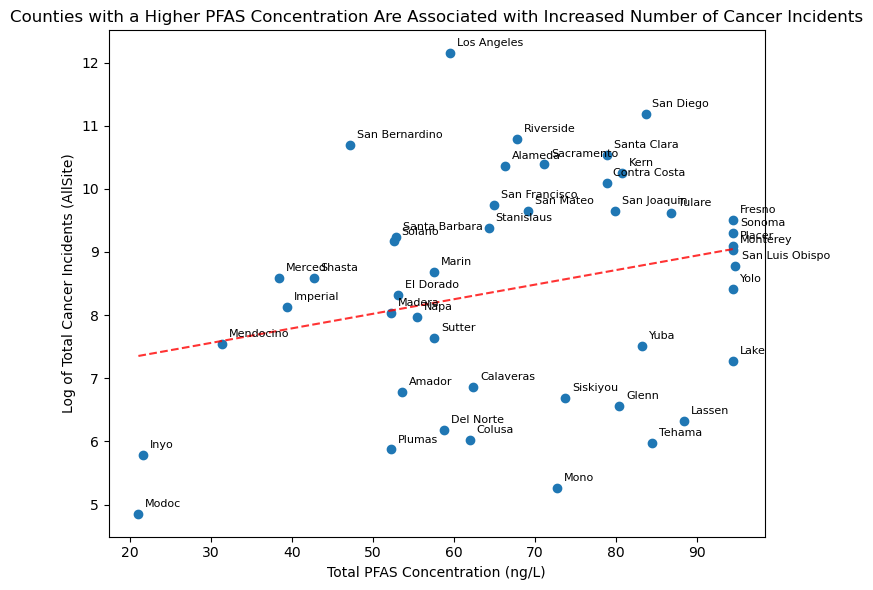

In [15]:
plot = hypothesis_plot(df)
plot.show()

## 📊 Machine Learning
To probe potential non-linear or complex relationships, we tested a simple Random Forest regressor against a baseline model.

In [4]:
from ml import predict_cancer_incidence

rf_rmse, gb_rmse, baseline_rmse = predict_cancer_incidence(df)

print(f"Random Forest RMSE: {rf_rmse**0.5:.3f}")
print(f"Gradient Boosting RMSE: {gb_rmse**0.5:.3f}")
print(f"Baseline RMSE: {baseline_rmse**0.5:.3f}")

Random Forest RMSE: 18815.094
Gradient Boosting RMSE: 18067.948
Baseline RMSE: 28628.803


Both advanced models outperform the baseline, demonstrating that the selected features (PFAS, cancer population, gender) capture relevant information. However, the absolute error remains high, suggesting that incorporating additional factors might further improve predictions.

## Reflection
- Hardest Part: Merging and cleaning heterogeneous datasets (cancer and PFAS) and standardizing county names.
- Initial Insights: Urban counties show high cancer incidents primarily due to larger populations. PFAS levels alone do not exhibit a strong linear relationship with cancer rates. ML analysis shows that while advanced models (Random Forest and Gradient Boosting) improve predictions over a baseline, error remains high.
- Concrete Results: A merged dataset and clear EDA results (including visualizations) have been produced. ML models yielded a Baseline RMSE of 28,628.803, Random Forest RMSE of 18,815.094, and Gradient Boosting RMSE of 18,067.948.
- Biggest Current Problems: The current feature set (PFAS, population, gender) is too limited to fully explain cancer incidence. Additional factors such as socioeconomic status, healthcare access, and environmental variables are needed.
- On Track & Worth Proceeding: Yes, we are on track. The initial results confirm that our approach captures some predictive signal. Enhancing the model with extra variables could lead to more actionable insights.


## Next Steps

- Feature Expansion: Integrate additional data (e.g., income, healthcare access, other environmental factors).
- Model Improvement: Experiment with advanced modeling techniques (e.g., cross-validation, feature importance analysis). Consider geospatial analyses using county shapefiles.
- Evaluation: Regularly update and assess model performance to ensure improvements over the baseline.
